# preparing

In [146]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import functions
from preprocess_dataframe import get_preprocess_dataframe
import os
import re
import glob
import math
import plotly.graph_objs as go
from shutil import copyfile
import time

## prepare paths

In [147]:
cycle_test=21

In [148]:
times=35

In [149]:
main_path='/media/alena/ext_space/job_analyze'
disabled_path="{}/disabled_folder{}".format(main_path,cycle_test)
frozen_path='{}/frozen_folder{}'.format(main_path,cycle_test)
learn_path='{}/learn_folder{}'.format(main_path,cycle_test)

## prepare func import dataframes

In [150]:
def readcsv(args):
    return pd.read_csv(args, header=None)

def get_df(path_folder,mode,times):
    
    df_ex_pl_time = pd.DataFrame()
    df_ex_pl_time_orig = pd.DataFrame()
    df_explains_plans = pd.DataFrame()
    df_query_err=pd.DataFrame()
    df_query_stat=pd.DataFrame()
    df_query_data=pd.DataFrame()
    filename_basics=glob.glob("{}/*_report.csv".format(path_folder, mode))
    if mode !='disabled':
        filename_others=['{}/{}_aqo_data.csv'.format(path_folder,mode), '{}/{}_aqo_query_stat.csv'.format(path_folder,mode)] 
        dfs = [df_query_data,df_query_err, df_query_stat]
    
    #print(filename_basics)
    for file in filename_basics:
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_list = []
            for file in filename_basics:
                df=pd.read_csv(file)
                df['Query hash'] = df['Query hash'].astype(str)
                df_list.append(df)
            df_ex_pl_time = pd.concat(df_list, ignore_index=True)
        else:
            df_ex_pl_time = df_list[0]
    if mode !='disabled':
        for k,file in enumerate(filename_others):
            dfs[k] = pd.read_csv(file)
    
    #explains
    dict_q={}
    dict_q_text={}
    lst=[]
    q=''
    plan=''
    k=0
    with open('{}/explains.txt'.format(path_folder)) as f:
        for line in f:
            str_=line
            if str_.replace(' ','')=='':
                continue
            if str_.find("QUERY PLAN")==0:
                if q not in list(dict_q.keys()):
                    dict_q[q]=1
                    dict_q_text[q]=[]
                    dict_q_text[q].append(re.sub(r'<b>\((.+)\)</b>', r'<b>\1</b>', str_))
                    #dict_q[q].append(str_)
                else:
                    str_=re.sub(r'<b>\((.+)\)</b>', r'<b>\1</b>', str_)
                    for i in list(dict_q_text[q]):
                        if i==str_:
                            dict_q[q]+=1
                            dict_q_text[q].append(str_)
                            break
                    #dict_q[q].append(str_)
                q=''
            else:
                q+=str_
    
    df_explains_plans = pd.DataFrame(dict_q.items())
    df_explains_plans.columns=['query_string', 'plans']
    #lst=[]
    #for i in df_explains_plans.itertuples(index=False):
    #    lst.append(len(i.plans)>1)
    #df_explains_plans['changed']=lst

    #report
    df_ex_pl_time = df_ex_pl_time.fillna(0)
    print(df_ex_pl_time)
    df_ex_pl_time = df_ex_pl_time.rename(columns = {'Plan time': 'plan_time',
                                         'Query Number':'query_number', 
                                         'Query Name':'query_name', 
                                         'Execution Time':'execution_time', 
                                         'Query hash':'query_hash'})
    df_ex_pl_time['query_number'] = df_ex_pl_time['query_number'].astype(int)
    df_ex_pl_time['query_hash'] = df_ex_pl_time['query_hash'].astype(str)
    df_ex_pl_time['plan_time'] = df_ex_pl_time['plan_time'].astype(float)
    df_ex_pl_time_orig=df_ex_pl_time.copy()
    if times>1:
        lst_data = []
        dict_query = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_name in dict_query:
                dict_query[i.query_name][1] += i.execution_time
                dict_query[i.query_name][3] += i.plan_time
            else:
                dict_query[i.query_name] = [i.query_name, i.execution_time, i.query_hash, i.plan_time]
        df_ex_pl_time = pd.DataFrame(dict_query.values(), columns = ['query_name', 'execution_time', 'query_hash', 'plan_time'])
        df_ex_pl_time['exec_time_avg'] = df_ex_pl_time['execution_time']/times
        df_ex_pl_time['plan_time_avg'] = df_ex_pl_time['plan_time']/times
    
    if mode !='disabled':
        #err
        filename_basics=glob.glob("{}/*_err*.csv".format(path_folder, mode))
        lst=[]
        df_list=[]
        def f(lst,k,l):
            lst_temp=[k]*l
            lst = lst+lst_temp
        #for file in filename_basics:
            #for iteration,file in enumerate(filename_basics):
            #    df_list.append(pd.read_csv(file))
            #    lst_temp=[iteration]*len(df_list)
            #    lst = lst+lst_temp
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_query_err = pd.concat(df_list, ignore_index=True)
        else:
            df_query_err = df_list[0]
        #df_list['iteration']=lst
        #print(df_query_err.columns)
        df_query_err['id'] = df_query_err['id'].astype(str)
        df_query_err['errdelta'] = df_query_err['errdelta'].astype(float)
    
        #stat
        df_query_stat=dfs[1].fillna(0)
        lst_stat_columns = ['execution_time_with_aqo', 'execution_time_without_aqo',
           'planning_time_with_aqo', 'planning_time_without_aqo',
           'cardinality_error_with_aqo', 'cardinality_error_without_aqo']
        lst_stat_cut = [1, 1, 1, 1, 1, 1]
        df_query_stat = get_preprocess_dataframe(df_query_stat, lst_stat_columns, lst_stat_cut)
        lst_min_val_with_aqo = []
        lst_min_iter_with_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.cardinality_error_with_aqo_split):
                if val < 0.1:
                    if min_val>val:
                        min_val = val
                        iteration = k
                    break
            lst_min_val_with_aqo.append(min_val)
            lst_min_iter_with_aqo.append(iteration)
        df_query_stat['min_iter_card_with'] = lst_min_iter_with_aqo
        df_query_stat['lst_min_val_with_aqo'] = lst_min_val_with_aqo
        

        lst_min_val_without_aqo = []
        lst_min_iter_without_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.cardinality_error_without_aqo_split):
                if min_val > val:
                    min_val = val
                    iteration = k
            lst_min_val_without_aqo.append(min_val)
            lst_min_iter_without_aqo.append(iteration)
        df_query_stat['min_iter_card_without'] = lst_min_iter_without_aqo
        df_query_stat['lst_min_val_without_aqo'] = lst_min_val_without_aqo

        lst_min_val_with_aqo = []
        lst_min_iter_with_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.execution_time_with_aqo_split):
                if min_val>val:
                    min_val = val
                    iteration = k
            lst_min_val_with_aqo.append(min_val)
            lst_min_iter_with_aqo.append(iteration)
        df_query_stat['min_iter_exec_with'] = lst_min_iter_with_aqo
        df_query_stat['lst_min_exec_with_aqo'] = lst_min_val_with_aqo

        lst_columns = ['cardinality_error_without_aqo_split', 'cardinality_error_with_aqo_split']
        lst_columns_with = ['planning_time_with_aqo_split', 'execution_time_with_aqo_split']
        lst_columns_without = ['planning_time_without_aqo_split', 'execution_time_without_aqo_split']
        for i,j,k in zip(lst_columns, lst_columns_with, lst_columns_without):
            df_query_stat = functions.last_errors(df_query_stat, i, '{}_last_value'.format(i))
            df_query_stat = functions.last_errors(df_query_stat, j,'{}_last_value'.format(i))
            df_query_stat = functions.last_errors(df_query_stat, k,'{}_last_value'.format(i))
        
        dict_hash = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_hash in dict_hash:
                dict_hash[str(i.query_hash)].append(i.query_name)
            else:
                dict_hash[i.query_hash] = []
                dict_hash[str(i.query_hash)].append(i.query_name)
        df_temp=pd.DataFrame(dict_hash.items())
        df_temp.columns=['queryid', 'query_name']
        df_temp['queryid'] = df_temp['queryid'].astype(str)
        df_query_stat['queryid'] = df_query_stat['queryid'].astype(str)
        #print(df_query_stat.columns)
        df_query_stat=df_query_stat.merge(df_temp, how='left', on='queryid')
        df_query_err=df_query_err.merge(df_temp,left_on='id', right_on='queryid')
        df_query_err['query_name'] = df_query_err['query_name'].astype(str)
        df_query_stat['query_name'] = df_query_stat['query_name'].astype(str)
        df_query_err=df_query_err.drop(columns=['queryid'])
    
    if mode !='disabled':
        return df_explains_plans, df_ex_pl_time, df_ex_pl_time_orig, df_query_err, df_query_stat
    else:
        return df_explains_plans, df_ex_pl_time

In [151]:
df_t=pd.read_csv('{}/frozen_aqo_query_stat.csv'.format(frozen_path))

In [152]:
len(df_t['execution_time_with_aqo'][0][1:-1].split(','))

19

In [153]:
learn_df_explains_plans, learn_df_ex_pl_time, learn_df_ex_pl_time_orig, learn_df_query_err, learn_df_query_stat=get_df(learn_path,'learn',times)

      Query Number Query Name  Execution Time  Plan time            Query hash
0               16    10a.sql         201.174     32.876  -6651533820180303979
1               16    10b.sql         101.803     26.106    988535410010893112
2               16    10c.sql        8465.481     27.122   2494719406442254794
3               16    11a.sql          44.031     61.078  -8754961486292191806
4               16    11b.sql          26.503     54.395   7102013096890644952
...            ...        ...             ...        ...                   ...
3837            23     8d.sql        2584.781     31.908  -2444720784039749802
3838            23     9a.sql        1482.428     68.932  -6747521538659772949
3839            23     9b.sql        1734.883     66.628    316739818532851506
3840            23     9c.sql        1569.537     68.973   -180252288200201541
3841            23     9d.sql        9406.169     59.011   7221379846823333251

[3842 rows x 5 columns]


/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a Dat

In [154]:
len(learn_df_query_stat['cardinality_error_with_aqo_split'].to_list()[0])

19

In [155]:
disabled_df_explains_plans, disabled_df_ex_pl_time=get_df(disabled_path,'disabled',1)

     Query Number Query Name  Execution Time  Plan time           Query hash
0               1    10a.sql        2518.775     26.606 -6651533820180303979
1               1    10b.sql         112.850     13.437   988535410010893112
2               1    10c.sql       13144.165     13.880  2494719406442254794
3               1    11a.sql         613.142     38.135 -8754961486292191806
4               1    11b.sql          39.298     29.808  7102013096890644952
..            ...        ...             ...        ...                  ...
108             1     8d.sql        4036.210     16.629 -2444720784039749802
109             1     9a.sql        3792.114     28.544 -6747521538659772949
110             1     9b.sql        1488.547     33.163   316739818532851506
111             1     9c.sql        1853.289     30.231  -180252288200201541
112             1     9d.sql       14354.942     62.473  7221379846823333251

[113 rows x 5 columns]


In [156]:
frozen_df_explains_plans, frozen_df_ex_pl_time, frozen_df_ex_pl_time_orig, frozen_df_query_err, frozen_df_query_stat=get_df(frozen_path,'frozen',1)

     Query Number Query Name  Execution Time  Plan time           Query hash
0               1    10a.sql         207.677     30.302 -6651533820180303979
1               1    10b.sql         117.889     23.069   988535410010893112
2               1    10c.sql        9011.491     24.456  2494719406442254794
3               1    11a.sql          46.065     69.248 -8754961486292191806
4               1    11b.sql          22.996     53.361  7102013096890644952
..            ...        ...             ...        ...                  ...
108             1     8d.sql        2478.884     34.611 -2444720784039749802
109             1     9a.sql        1388.526     62.946 -6747521538659772949
110             1     9b.sql        1581.645     66.288   316739818532851506
111             1     9c.sql        1678.571     75.449  -180252288200201541
112             1     9d.sql        9599.542     58.808  7221379846823333251

[113 rows x 5 columns]


/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a Dat

In [157]:
frozen_df_ex_pl_time

query_number query_name  execution_time  plan_time            query_hash
0               1    10a.sql         207.677     30.302  -6651533820180303979
1               1    10b.sql         117.889     23.069    988535410010893112
2               1    10c.sql        9011.491     24.456   2494719406442254794
3               1    11a.sql          46.065     69.248  -8754961486292191806
4               1    11b.sql          22.996     53.361   7102013096890644952
..            ...        ...             ...        ...                   ...
108             1     8d.sql        2478.884     34.611  -2444720784039749802
109             1     9a.sql        1388.526     62.946  -6747521538659772949
110             1     9b.sql        1581.645     66.288    316739818532851506
111             1     9c.sql        1678.571     75.449   -180252288200201541
112             1     9d.sql        9599.542     58.808   7221379846823333251

[113 rows x 5 columns]

In [10]:
frozen_df_ex_pl_time[frozen_df_ex_pl_time['query_name']=='32a.sql']

query_number query_name  execution_time  plan_time           query_hash
82             1    32a.sql          18.688     46.306  6225652705960457954

## Main report analyze

In [158]:
frozen_df_ex_pl_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   query_number    113 non-null    int64  
 1   query_name      113 non-null    object 
 2   execution_time  113 non-null    float64
 3   plan_time       113 non-null    float64
 4   query_hash      113 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 4.5+ KB


In [159]:
# frozen_df_ex_pl_time, frozen_df_ex_pl_time, frozen_df_query_err, frozen_df_query_stat

In [160]:
def renames(df, mode):
    df = df.rename(columns = {'plan_time':'plan_time_{}'.format(mode), 'execution_time':'execution_time_{}'.format(mode)})
    if mode == 'control' or mode == 'disabled':
        df = df.rename(columns = {'plan_time_avg':'plan_time_avg_{}'.format(mode), 'exec_time_avg':'exec_time_avg_{}'.format(mode)})
    return df

In [161]:
frozen_df_ex_pl_time=renames(frozen_df_ex_pl_time,'frozen')


In [162]:
disabled_df_ex_pl_time=renames(disabled_df_ex_pl_time,'disabled')

In [163]:
learn_df_ex_pl_time=renames(learn_df_ex_pl_time,'learn')

In [164]:
disabled_df_ex_pl_time

query_number query_name  execution_time_disabled  plan_time_disabled  \
0               1    10a.sql                 2518.775              26.606   
1               1    10b.sql                  112.850              13.437   
2               1    10c.sql                13144.165              13.880   
3               1    11a.sql                  613.142              38.135   
4               1    11b.sql                   39.298              29.808   
..            ...        ...                      ...                 ...   
108             1     8d.sql                 4036.210              16.629   
109             1     9a.sql                 3792.114              28.544   
110             1     9b.sql                 1488.547              33.163   
111             1     9c.sql                 1853.289              30.231   
112             1     9d.sql                14354.942              62.473   

               query_hash  
0    -6651533820180303979  
1      988535410010893112  
2     2494719406442254794  
3    -8754961486292191806  
4     7102013096890644952  
..                    ...  
108  -2444720784039749802  
109  -6747521538659772949  
110    316739818532851506  
111   -180252288200201541  
112   7221379846823333251  

[113 rows x 5 columns]

In [165]:
df_ex_pl_time = frozen_df_ex_pl_time.merge(disabled_df_ex_pl_time, how='left', on=['query_name','query_number','query_hash'])

In [166]:
#df = df.merge(learn_df_ex_pl_time, how='left', on=['query_name','query_hash'])

In [167]:
df_ex_pl_time

query_number query_name  execution_time_frozen  plan_time_frozen  \
0               1    10a.sql                207.677            30.302   
1               1    10b.sql                117.889            23.069   
2               1    10c.sql               9011.491            24.456   
3               1    11a.sql                 46.065            69.248   
4               1    11b.sql                 22.996            53.361   
..            ...        ...                    ...               ...   
108             1     8d.sql               2478.884            34.611   
109             1     9a.sql               1388.526            62.946   
110             1     9b.sql               1581.645            66.288   
111             1     9c.sql               1678.571            75.449   
112             1     9d.sql               9599.542            58.808   

               query_hash  execution_time_disabled  plan_time_disabled  
0    -6651533820180303979                 2518.775              26.606  
1      988535410010893112                  112.850              13.437  
2     2494719406442254794                13144.165              13.880  
3    -8754961486292191806                  613.142              38.135  
4     7102013096890644952                   39.298              29.808  
..                    ...                      ...                 ...  
108  -2444720784039749802                 4036.210              16.629  
109  -6747521538659772949                 3792.114              28.544  
110    316739818532851506                 1488.547              33.163  
111   -180252288200201541                 1853.289              30.231  
112   7221379846823333251                14354.942              62.473  

[113 rows x 7 columns]

In [168]:
learn_df_ex_pl_time_orig

query_number query_name  execution_time  plan_time            query_hash
0               16    10a.sql         201.174     32.876  -6651533820180303979
1               16    10b.sql         101.803     26.106    988535410010893112
2               16    10c.sql        8465.481     27.122   2494719406442254794
3               16    11a.sql          44.031     61.078  -8754961486292191806
4               16    11b.sql          26.503     54.395   7102013096890644952
...            ...        ...             ...        ...                   ...
3837            23     8d.sql        2584.781     31.908  -2444720784039749802
3838            23     9a.sql        1482.428     68.932  -6747521538659772949
3839            23     9b.sql        1734.883     66.628    316739818532851506
3840            23     9c.sql        1569.537     68.973   -180252288200201541
3841            23     9d.sql        9406.169     59.011   7221379846823333251

[3842 rows x 5 columns]

## err_data

In [169]:
frozen_df_query_err

id  errdelta   query_name
0   -9026514954839072455  1.616243  ['12a.sql']
1   -8754961486292191806  2.017878  ['11a.sql']
2   -7994933085961275538  1.152005  ['23b.sql']
3   -7971004576533452411  2.250916  ['21c.sql']
4   -7678011977838348522  1.662952   ['7c.sql']
..                   ...       ...          ...
90   7519382914444524780  3.287132  ['31a.sql']
91   7721649514993682563  0.964366  ['30b.sql']
92   7915967579038312663  1.782592  ['19d.sql']
93   9105500078934324812  3.255533  ['25c.sql']
94   9106003620751043838  2.050714   ['5a.sql']

[95 rows x 3 columns]

In [170]:
def renames(df, mode, column):
    df = df.rename(columns = {column:'{}_{}'.format(column,mode)})
    return df

In [171]:
learn_df_query_err=renames(learn_df_query_err,'learn','errdelta')

In [172]:
frozen_df_query_err=renames(frozen_df_query_err,'frozen','errdelta')

In [173]:
df_err = learn_df_query_err.merge(frozen_df_query_err, how='left', on=['id', 'query_name'])

In [174]:
df_err

id  errdelta_learn                      query_name  \
0       988535410010893112        0.000000                     ['10b.sql']   
1       988535410010893112        0.000000                     ['10b.sql']   
2       988535410010893112        0.000000                     ['10b.sql']   
3       988535410010893112        0.000000                     ['10b.sql']   
4       988535410010893112        0.000000                     ['10b.sql']   
...                    ...             ...                             ...   
3320  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
3321  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
3322  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
3323  -1950505845315524548        0.973322  ['4a.sql', '4b.sql', '4c.sql']   
3324  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   

      errdelta_frozen  
0            1.197399  
1            1.197399  
2            1.197399  
3            1.197399  
4            1.197399  
...               ...  
3320         1.057462  
3321         1.057462  
3322         1.057462  
3323         1.057462  
3324         1.057462  

[3325 rows x 4 columns]

## learn_df_query_stat

In [175]:
learn_df_query_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   queryid                                         95 non-null     object 
 1   cardinality_error_without_aqo_split             95 non-null     object 
 2   cardinality_error_with_aqo_split                95 non-null     object 
 3   planning_time_without_aqo_split                 95 non-null     object 
 4   planning_time_with_aqo_split                    95 non-null     object 
 5   execution_time_without_aqo_split                95 non-null     object 
 6   execution_time_with_aqo_split                   95 non-null     object 
 7   executions_with_aqo                             95 non-null     int64  
 8   executions_without_aqo                          95 non-null     int64  
 9   min_iter_card_with                           

In [176]:
learn_df_query_stat

queryid                cardinality_error_without_aqo_split  \
0     988535410010893112                               [1.1973993742845448]   
1   -6651533820180303979                               [0.7194302660038193]   
2   -3414057395363075461                               [0.9535934648818055]   
3    3350265702090035455                               [3.3309763436625217]   
4    -917204397272063480                               [3.2633813112437693]   
..                   ...                                                ...   
90  -6885312641126422993                                [2.432924086921854]   
91  -1889760809355916724                                [2.812665176668648]   
92  -6571914703387389993                               [1.0491588080704786]   
93   -460740518707800565                               [0.9070590227413717]   
94  -1950505845315524548  [0.9791415628673305, 0.43630343429060897, 1.06...   

                     cardinality_error_with_aqo_split  \
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4   [0.04699718918678322, 0.017621962358924756, 0....   
..                                                ...   
90  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
91  [1.5959811441045022, 0.05338654940017887, 0.00...   
92  [0.0036089565574195276, 0.0036089565574195276,...   
93  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
94  [0.011538125913381528, 0.025015150933378454, 0...   

            planning_time_without_aqo_split  \
0                             [0.013328599]   
1                             [0.026532126]   
2                             [0.008796801]   
3                             [0.028110362]   
4                              [0.02097922]   
..                                      ...   
90                            [0.007251653]   
91                            [0.318759949]   
92                            [0.323461564]   
93                            [0.064528428]   
94  [0.007364701, 0.007499541, 0.008237995]   

                         planning_time_with_aqo_split  \
0   [0.02607165, 0.026364898, 0.026838163, 0.02748...   
1   [0.032843106, 0.033976709, 0.031639636, 0.0306...   
2   [0.015415152, 0.018611165, 0.016028334, 0.0152...   
3   [0.052296671, 0.056458054, 0.051228763, 0.0473...   
4   [0.034765172, 0.037754552, 0.035199055, 0.0337...   
..                                                ...   
90  [0.013010422, 0.01327941, 0.014793134, 0.01299...   
91  [2.646650095, 3.056965264, 2.947018575, 2.6229...   
92  [5.409503806, 5.396519176, 5.278647151, 5.6596...   
93  [0.11832549, 0.108062192, 0.107233379, 0.10761...   
94  [0.012487156, 0.011652769, 0.014375206, 0.0123...   

           execution_time_without_aqo_split  \
0                             [0.113734554]   
1                      [2.5214877060000003]   
2                             [0.170372451]   
3                            [55.537751228]   
4                            [35.606235867]   
..                                      ...   
90                            [0.101933066]   
91                            [1.650203901]   
92                            [0.042353235]   
93                            [0.643301635]   
94  [0.199733573, 0.128297623, 0.232824369]   

                        execution_time_with_aqo_split  executions_with_aqo  \
0   [0.102996816, 0.102158973, 0.100839931, 0.1012...                   34   
1   [0.202374087, 0.187331974, 0.189826482, 0.1825...                   34   
2   [0.172735702, 0.224272353, 0.17789916, 0.17602...                   34   
3   [10.447891804, 10.735650487000001, 10.91341915...                   34   
4   [14.556416143, 13.99166912, 14.066572408, 14.0...                   34   
..                                                ...                  ...   
90  [0.101118331, 0.10

# build graphs: learning

In [216]:
def upload_pics(contain, dir_to, filename):
    plotly.offline.plot(contain, image_filename=filename, image='svg')
    time.sleep(10)
    #os.replace('{}/{}.svg'.format('/home/alena/Downloads', filename), '{}/{}.svg'.format(dir_to, filename))

## err for every query

### err_data

In [217]:
learn_df_query_err

id  errdelta_learn                      query_name  \
0       988535410010893112        0.000000                     ['10b.sql']   
1       988535410010893112        0.000000                     ['10b.sql']   
2       988535410010893112        0.000000                     ['10b.sql']   
3       988535410010893112        0.000000                     ['10b.sql']   
4       988535410010893112        0.000000                     ['10b.sql']   
...                    ...             ...                             ...   
3320  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
3321  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
3322  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
3323  -1950505845315524548        0.973322  ['4a.sql', '4b.sql', '4c.sql']   
3324  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   

      iter  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
3320    34  
3321    34  
3322    34  
3323    34  
3324    34  

[3325 rows x 4 columns]

In [218]:
lst_queries=learn_df_query_err['id'].unique()

In [219]:
lst=[]
for k in range(times):
    lst += [k]*len(lst_queries)
    if len(lst)==len(learn_df_query_err):
        break

In [220]:
len(lst), len(learn_df_query_err)

(3325, 3325)

In [221]:
learn_df_query_err['iter']=lst

In [222]:
name_query = list(learn_df_query_err['query_name'].unique())

In [223]:
from plotly.subplots import make_subplots

In [224]:
ox=list(x for x in range(times))

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[1142773:1142773:0329/140007.772125:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


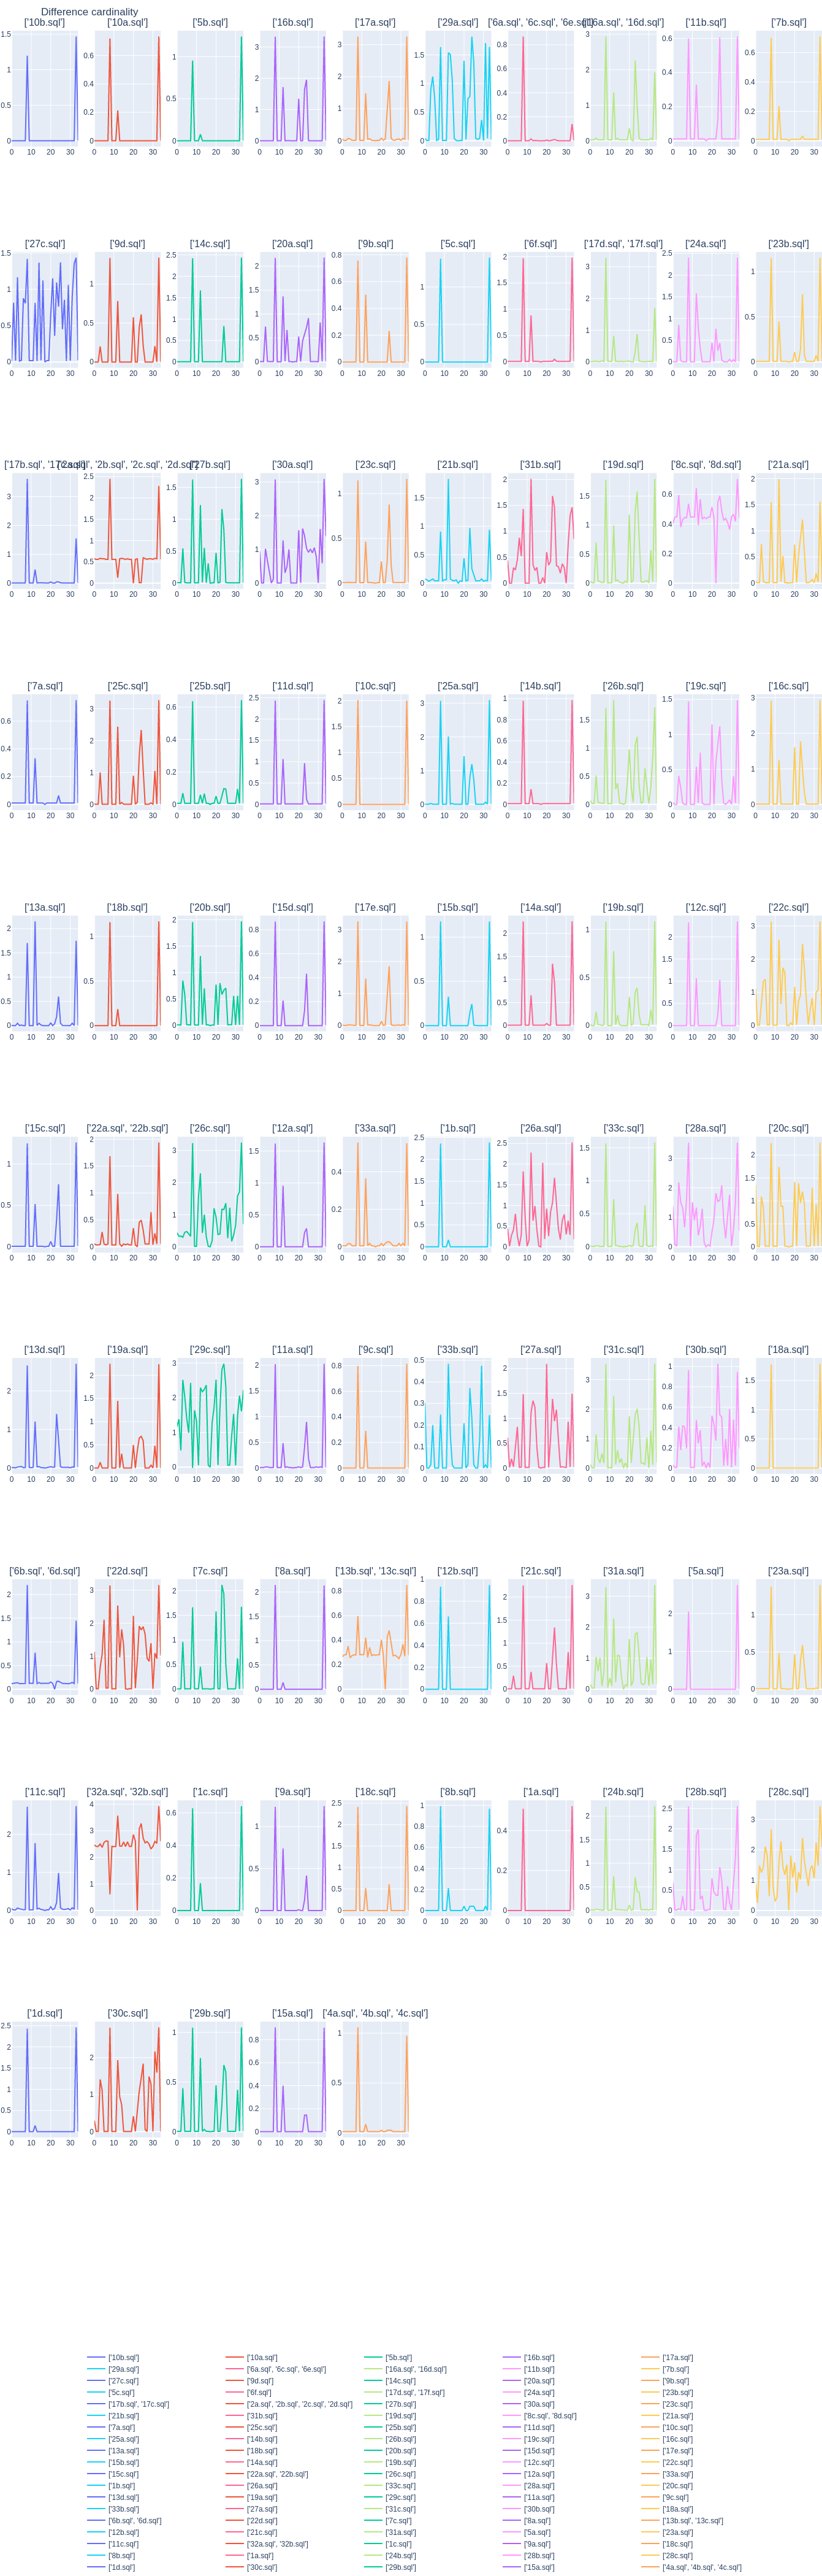

In [225]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_err[learn_df_query_err['query_name']==i]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['errdelta_learn']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                   title_text="Difference cardinality",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=4000, height = 4200)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Difference cardinality')
os.rename('temp-plot.html', '{}_learn_Difference cardinality.html'.format(cycle_test))
fig.show()

### query_stats

In [ ]:
name_query=list(learn_df_query_stat['query_name'])

In [ ]:
df_temp=learn_df_query_stat[learn_df_query_stat['query_name']=="['15a.sql']"]

In [ ]:
df_temp['cardinality_error_with_aqo_split'].to_list()[0]

In [43]:
oy=df_temp['cardinality_error_with_aqo_split'].to_list()

In [44]:
ox=list(x for x in range(len(df_temp['cardinality_error_with_aqo_split'].to_list()[0])))

In [45]:
ox

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [46]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['cardinality_error_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['cardinality_error_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(title_text="Error cardinality for learn by aqo_query_stat",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=4000, height = 2200)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Error cardinality for learn by aqo_query_stat')
os.rename('temp-plot.html', '{}_Error cardinality for learn by aqo_query_stat.html'.format(cycle_test))
fig.show()

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[1122141:1122141:0329/124657.462297:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


## execution for every query

### learn_df_ex_pl_time_orig

In [226]:
name_query = list(learn_df_query_err['query_name'].unique())

In [227]:
ox=list(x for x in range(times))

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[1143435:1143435:0329/140135.260949:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


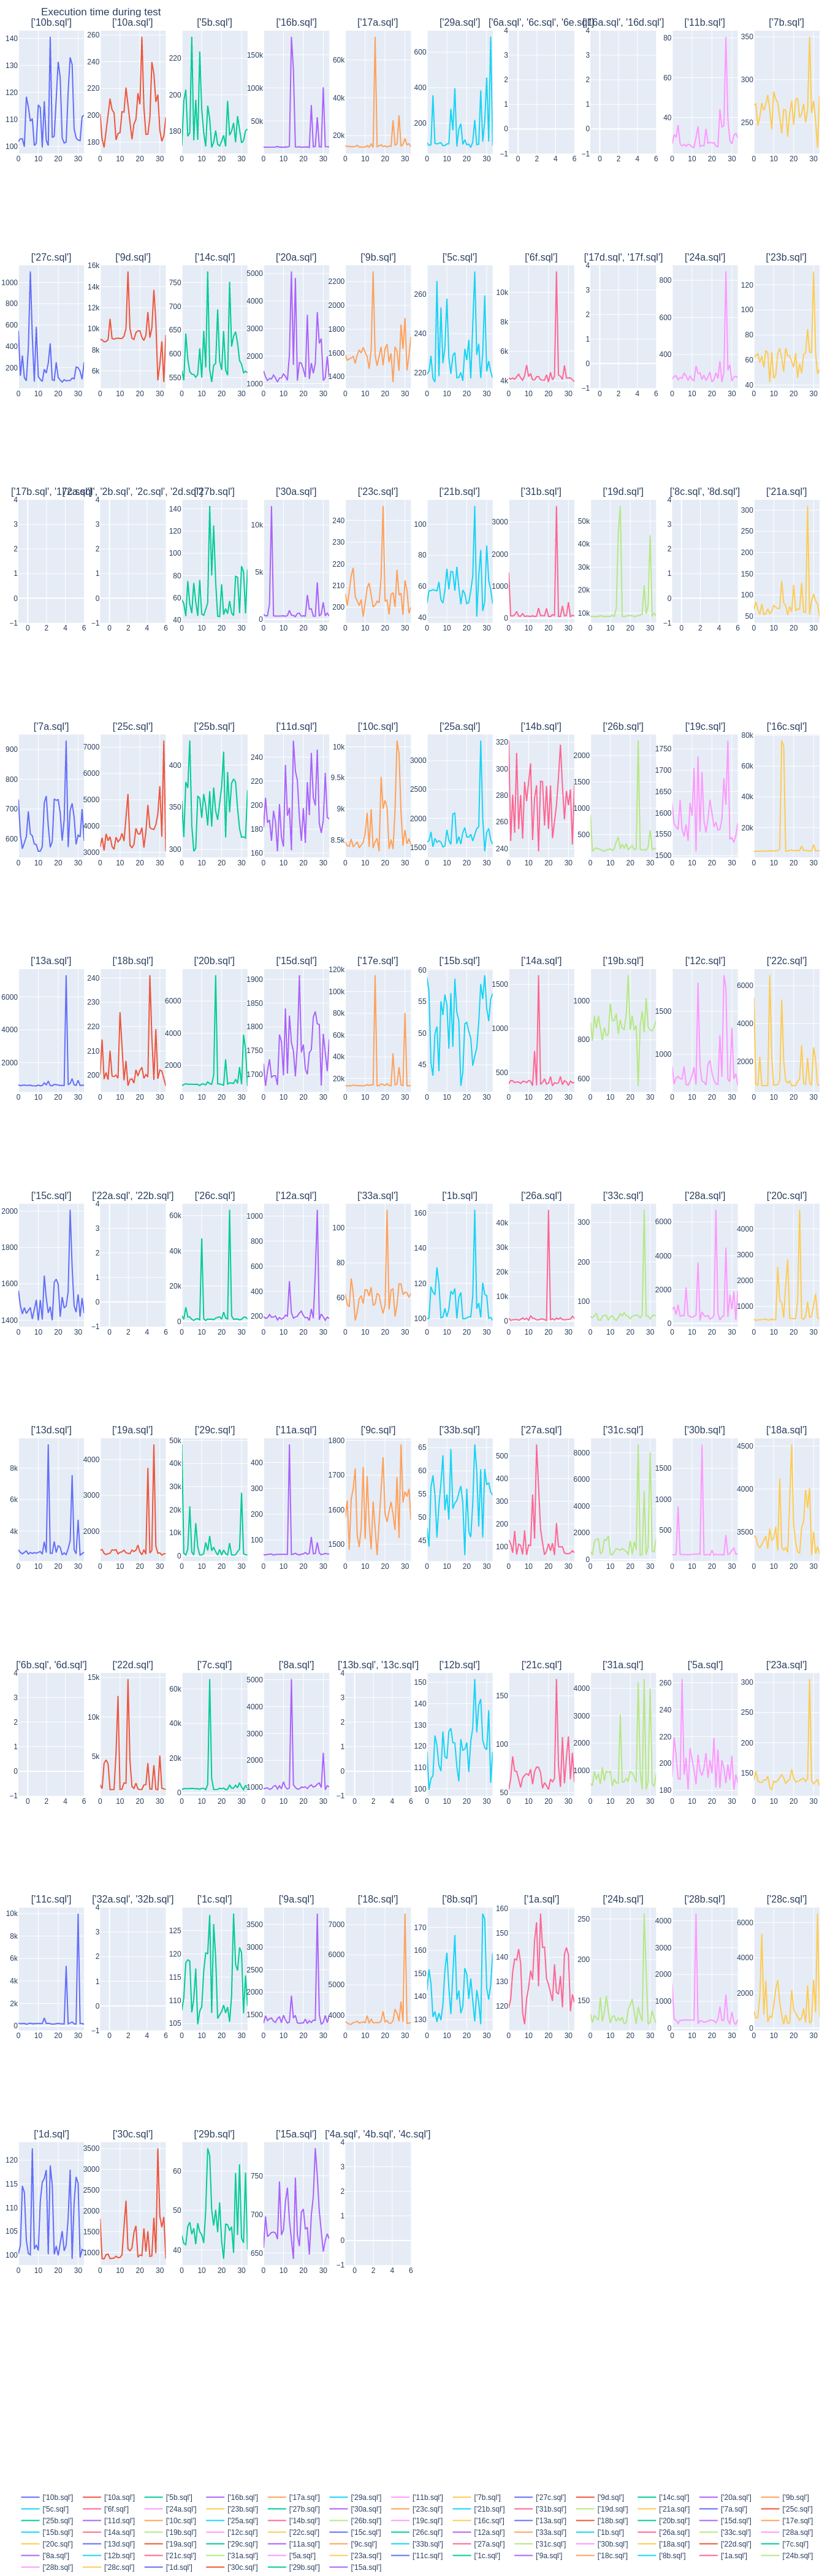

In [228]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_ex_pl_time_orig[learn_df_ex_pl_time_orig['query_name']==i[2:-2]]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['execution_time']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  title_text="Execution time during test",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=4000, height = 4200)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Execution time during test')
os.rename('temp-plot.html', '{}_Execution time during test.html'.format(cycle_test))
fig.show()

### learn_df_query_stat

In [50]:
name_query=list(learn_df_query_stat['query_name'])

In [51]:
df_temp=learn_df_query_stat[learn_df_query_stat['query_name']=="['15a.sql']"]

In [52]:
ox=list(x for x in range(len(df_temp['execution_time_with_aqo_split'].to_list()[0])))

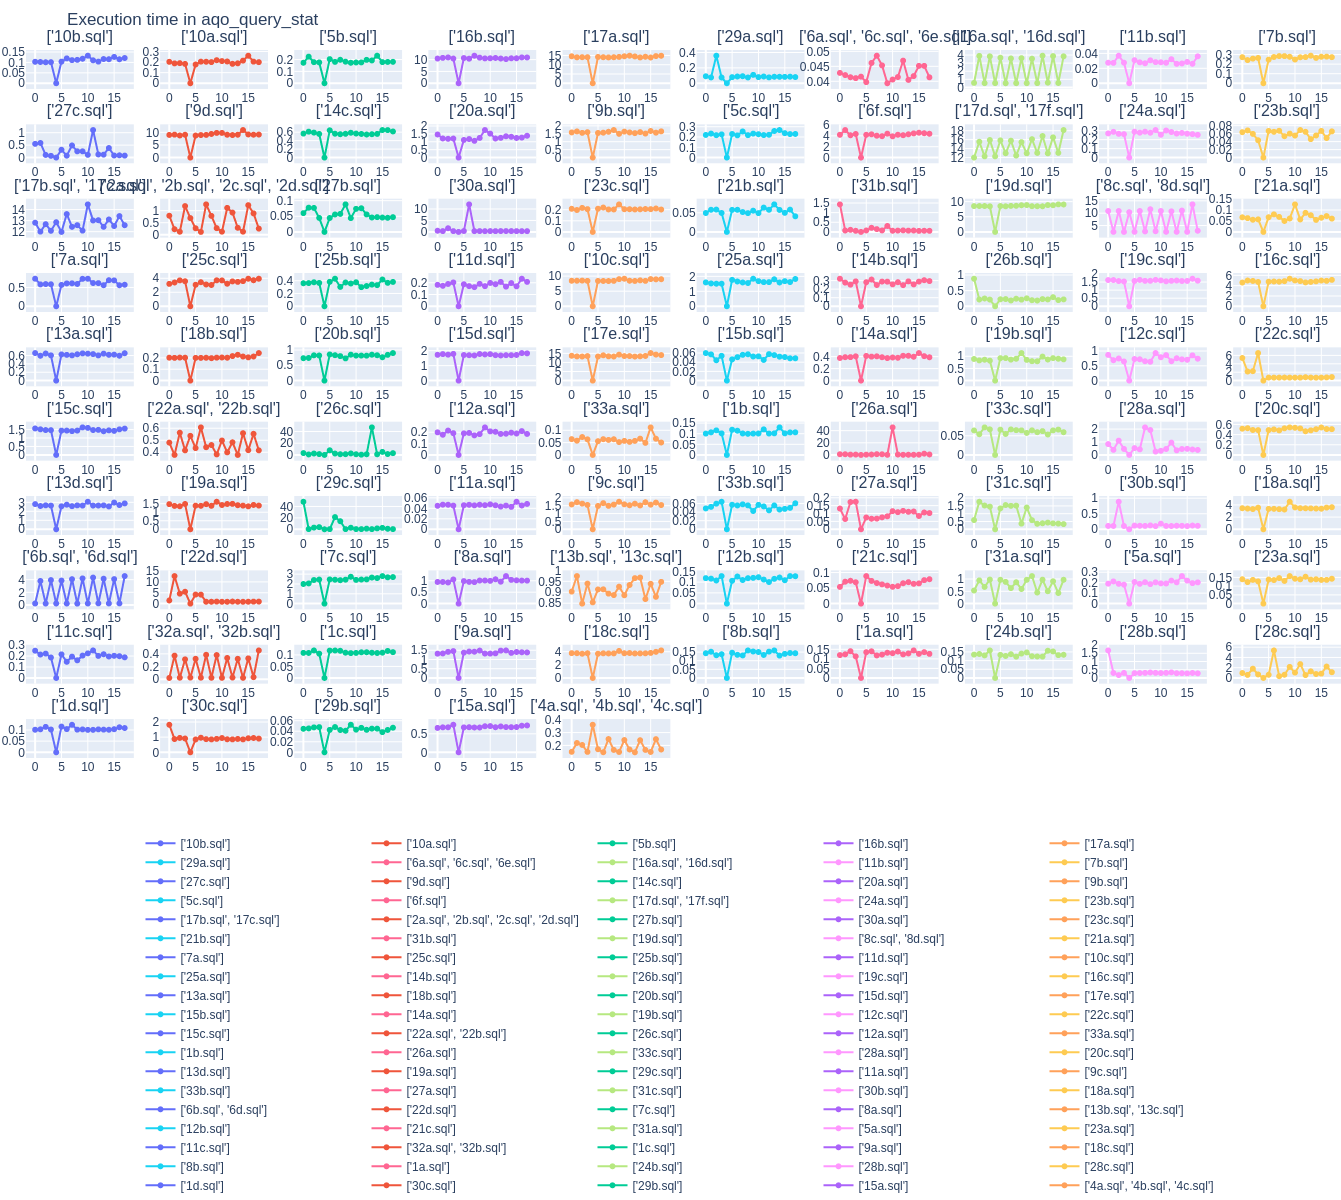

In [53]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['execution_time_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['execution_time_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  title_text="Execution time in aqo_query_stat",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Execution time in aqo_query_stat')
os.rename('temp-plot.html', '{}_Execution time in aqo_query_stat.html'.format(cycle_test))
fig.show()

## plan for every query

### learn_df_ex_pl_time_orig

In [54]:
name_query = list(learn_df_query_err['query_name'].unique())

In [55]:
ox=list(x for x in range(times))

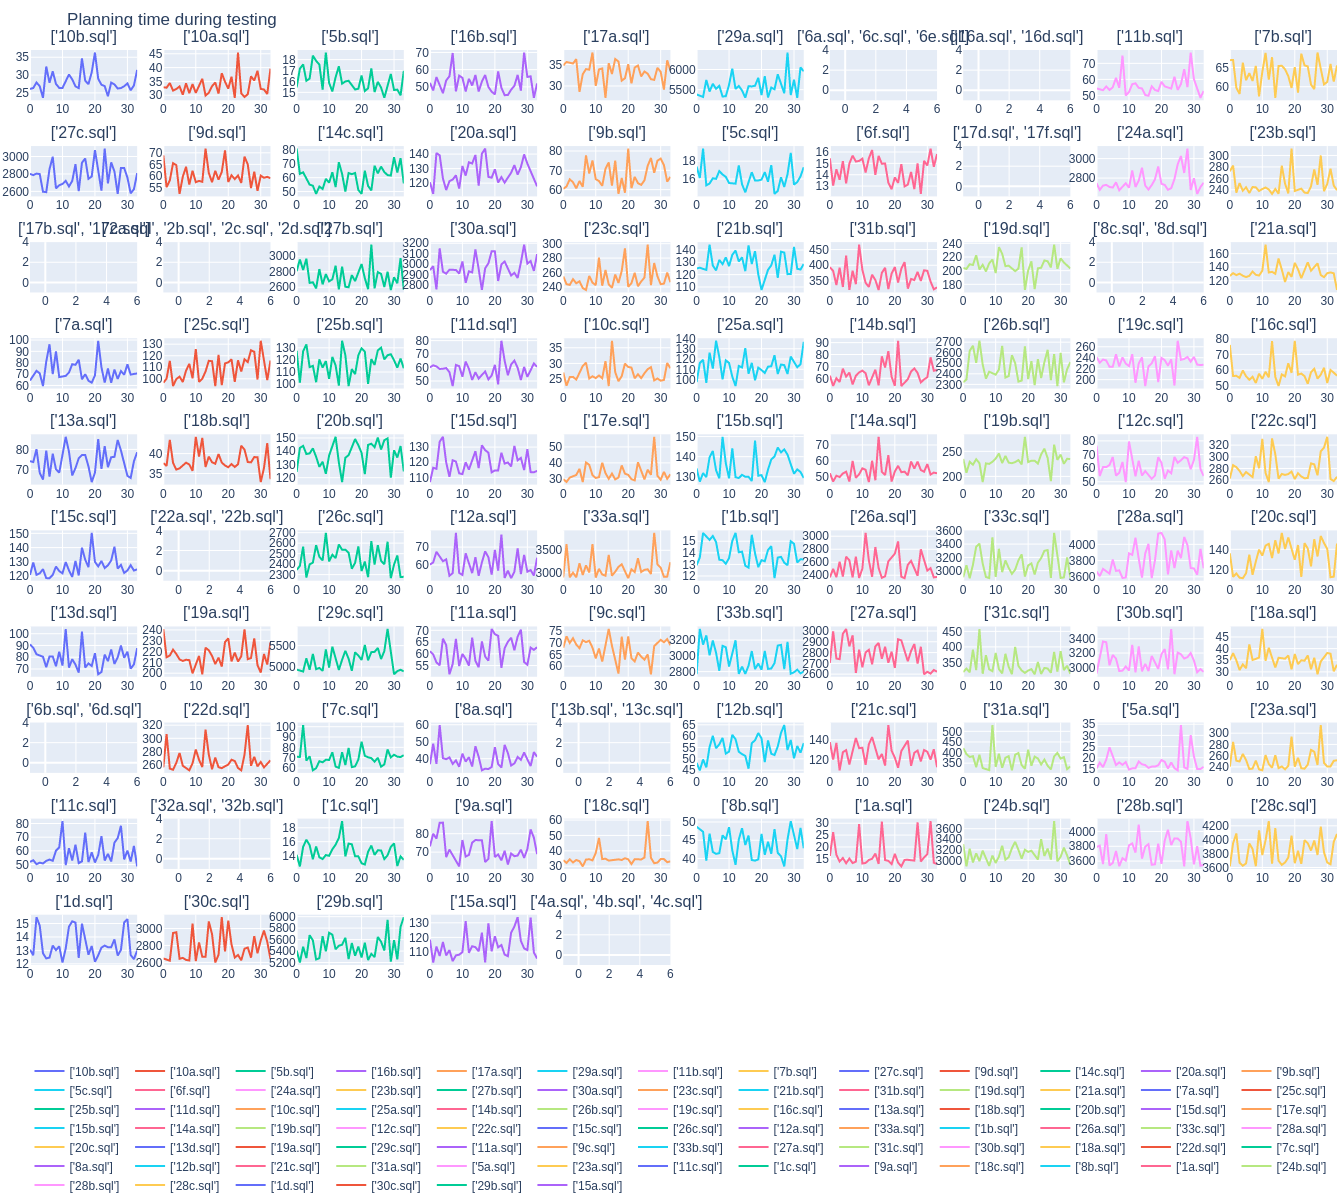

In [56]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_ex_pl_time_orig[learn_df_ex_pl_time_orig['query_name']==i[2:-2]]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['plan_time']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  title='Planning time during testing',
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Planning time during testing')
os.rename('temp-plot.html', '{}_Planning time during testing.html'.format(cycle_test))
fig.show()

### aqo_query_stat

In [57]:
name_query=list(learn_df_query_stat['query_name'])

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[1122328:1122328:0329/124713.083345:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


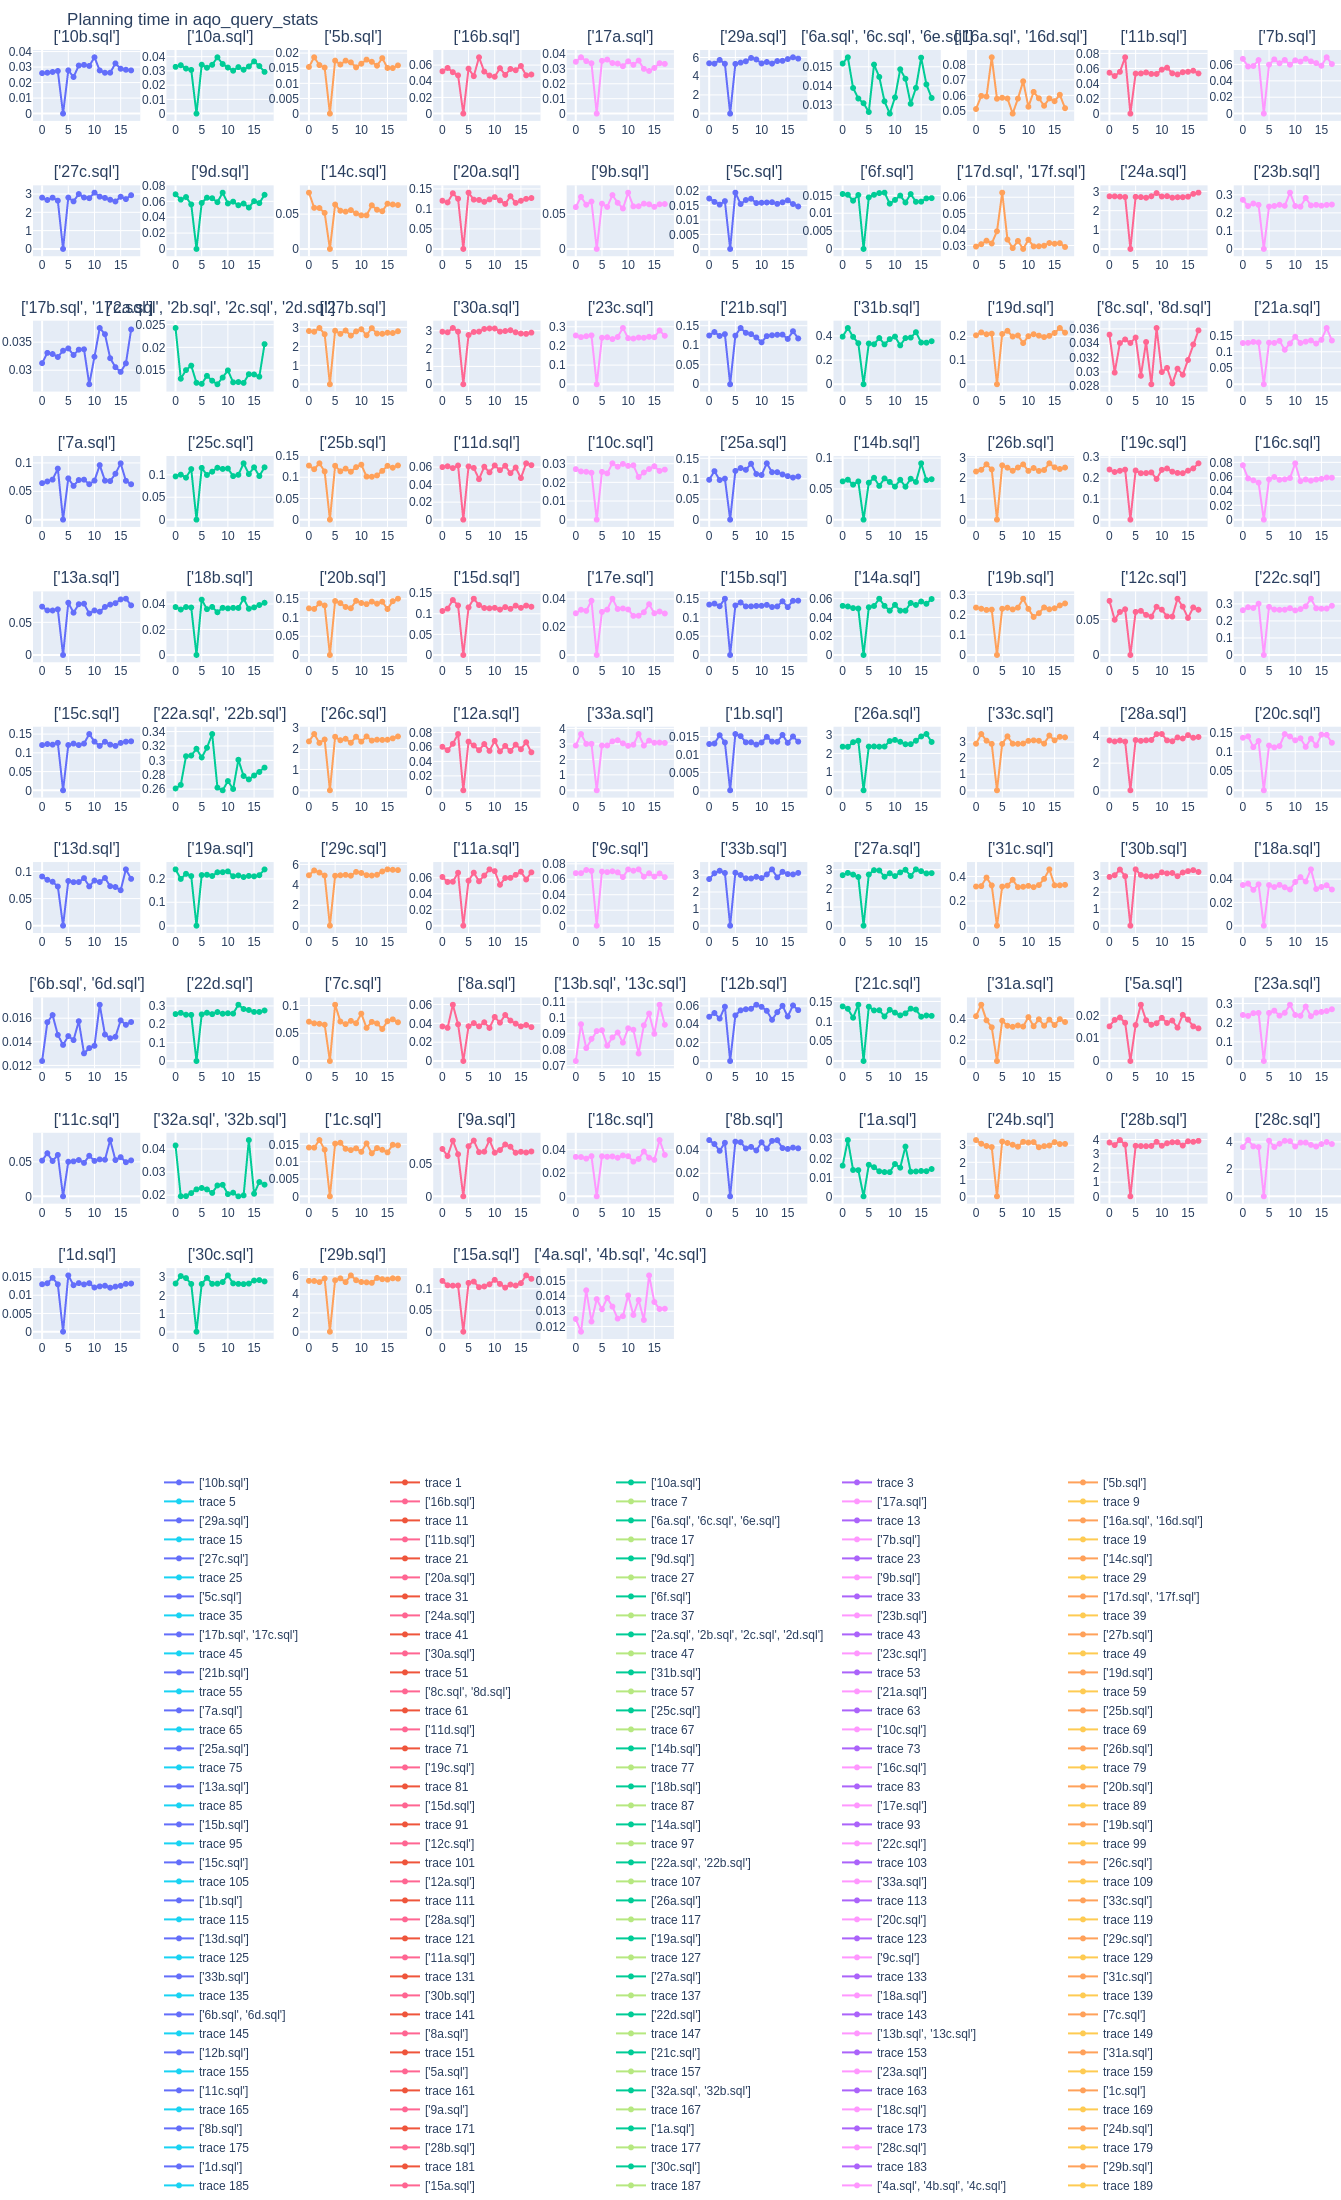

In [58]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['planning_time_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['planning_time_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    fig.add_trace(go.Scatter(x = ox, y = df_temp['planning_time_without_aqo_split'])
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title='Planning time in aqo_query_stats',
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=4000, height = 2200)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Planning time in aqo_query_stats')
os.rename('temp-plot.html', '{}_Planning time in aqo_query_stats.html'.format(cycle_test))
fig.show()

# build graphs: disabled and control

## query with plan and execution time

### df_ex_pl_time

In [59]:
df_ex_pl_time_copy=df_ex_pl_time.copy()

In [60]:
df_ex_pl_time_copy

query_number query_name  execution_time_frozen  plan_time_frozen  \
0               1    10a.sql                207.677            30.302   
1               1    10b.sql                117.889            23.069   
2               1    10c.sql               9011.491            24.456   
3               1    11a.sql                 46.065            69.248   
4               1    11b.sql                 22.996            53.361   
..            ...        ...                    ...               ...   
108             1     8d.sql               2478.884            34.611   
109             1     9a.sql               1388.526            62.946   
110             1     9b.sql               1581.645            66.288   
111             1     9c.sql               1678.571            75.449   
112             1     9d.sql               9599.542            58.808   

               query_hash  execution_time_disabled  plan_time_disabled  
0    -6651533820180303979                 2518.775              26.606  
1      988535410010893112                  112.850              13.437  
2     2494719406442254794                13144.165              13.880  
3    -8754961486292191806                  613.142              38.135  
4     7102013096890644952                   39.298              29.808  
..                    ...                      ...                 ...  
108  -2444720784039749802                 4036.210              16.629  
109  -6747521538659772949                 3792.114              28.544  
110    316739818532851506                 1488.547              33.163  
111   -180252288200201541                 1853.289              30.231  
112   7221379846823333251                14354.942              62.473  

[113 rows x 7 columns]

In [61]:
df_ex_pl_time_copy['diff_exec_time']=df_ex_pl_time_copy['execution_time_disabled']-df_ex_pl_time_copy['execution_time_frozen']

In [62]:
df_ex_pl_time_copy['rate_exec_time']=df_ex_pl_time_copy['execution_time_disabled']/df_ex_pl_time_copy['execution_time_frozen']

In [63]:
df_ex_pl_time_copy['diff_plan_time']=df_ex_pl_time_copy['plan_time_disabled']-df_ex_pl_time_copy['plan_time_frozen']

In [64]:
df_ex_pl_time_copy['rate_plan_time']=df_ex_pl_time_copy['plan_time_disabled']/df_ex_pl_time_copy['plan_time_frozen']

In [207]:
len(df_ex_pl_time_copy[df_ex_pl_time_copy['diff_plan_time']+df_ex_pl_time_copy['diff_exec_time']>=0]), len(df_ex_pl_time_copy[df_ex_pl_time_copy['diff_plan_time']+df_ex_pl_time_copy['diff_exec_time']<0])

(56, 57)

In [65]:
exec_rate_2x=df_ex_pl_time_copy[df_ex_pl_time_copy['rate_exec_time']>=2]
plan_rate_2x=df_ex_pl_time_copy[df_ex_pl_time_copy['rate_plan_time']>=2]

In [66]:
exec_rate_1x=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<2) & (df_ex_pl_time_copy['rate_exec_time']>=1)]
plan_rate_1x=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<2) & (df_ex_pl_time_copy['rate_plan_time']>=1)]

In [67]:
exec_rate_more_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<1) & (df_ex_pl_time_copy['rate_exec_time']>=0)]
plan_rate_more_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<1) & (df_ex_pl_time_copy['rate_plan_time']>=0)]

In [68]:
exec_rate_less_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<0)]
plan_rate_less_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<0)]

In [208]:
lst_exec=[len(exec_rate_2x), len(exec_rate_1x), len(exec_rate_more_0)]
lst_plan=[len(plan_rate_2x), len(plan_rate_1x), len(plan_rate_more_0)]
lst_sum=[len(df_ex_pl_time_copy[df_ex_pl_time_copy['diff_plan_time']+df_ex_pl_time_copy['diff_exec_time']>=0]), len(df_ex_pl_time_copy[df_ex_pl_time_copy['diff_plan_time']+df_ex_pl_time_copy['diff_exec_time']<0])]

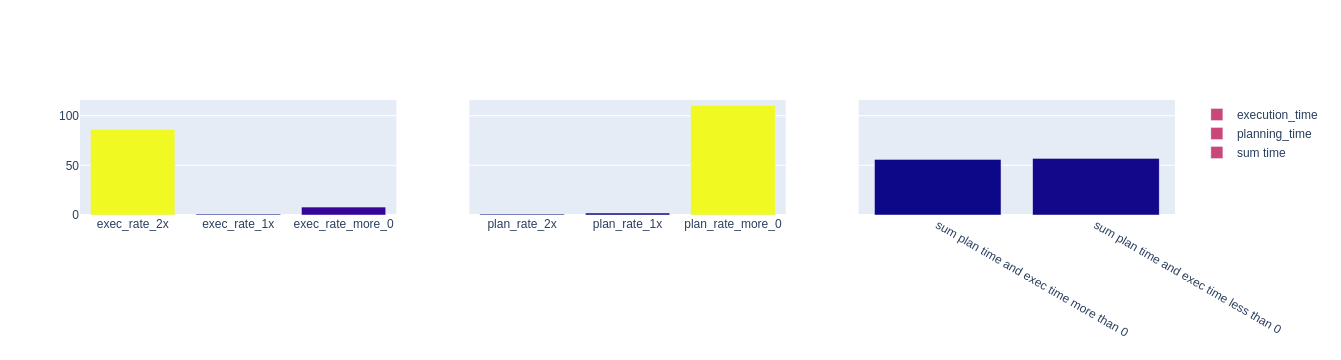

In [215]:
fig = make_subplots(rows=1, cols=3, shared_yaxes=True)
fig.add_trace(go.Bar(name='execution_time', x=['exec_rate_2x', 'exec_rate_1x', 'exec_rate_more_0'], y=lst_exec,
                    marker=dict(color=lst_exec)),
              1, 1)
fig.add_trace(go.Bar(name='planning_time', x=['plan_rate_2x', 'plan_rate_1x', 'plan_rate_more_0'], y=lst_plan,
                    marker=dict(color=lst_plan)),
              1, 2)
fig.add_trace(go.Bar(name='sum time', x=['sum plan time and exec time more than 0', 'sum plan time and exec time less than 0'], y=lst_sum,
                    marker=dict(color=lst_plan)),
              1, 3)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'execution time effective')
os.rename('temp-plot.html', '{}_execution time effective.html'.format(cycle_test))
fig.show()

In [229]:
df_filter=df_ex_pl_time_copy[df_ex_pl_time_copy['diff_plan_time']+df_ex_pl_time_copy['diff_exec_time']>=0]

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[1144100:1144100:0329/140710.308900:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


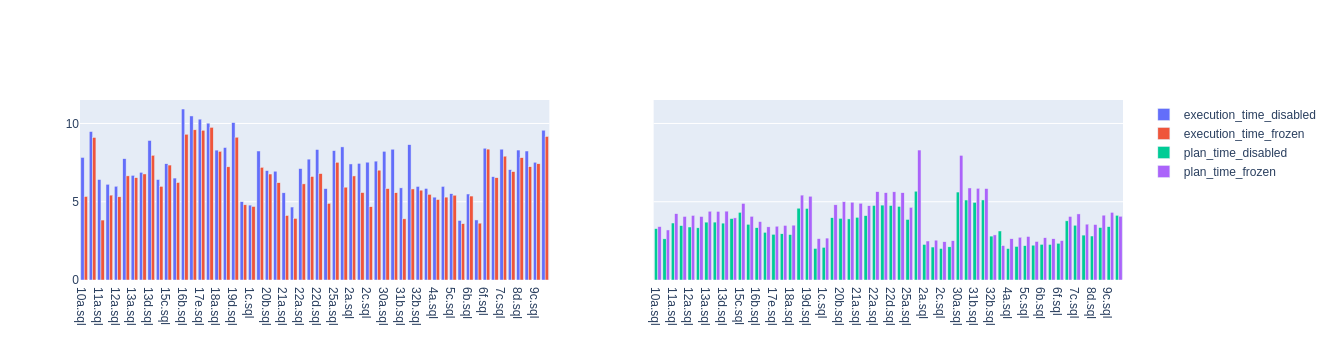

In [231]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(go.Bar(name='execution_time_disabled', x=df_filter['query_name'], y=np.log(df_filter['execution_time_disabled'])),
              1, 1)
fig.add_trace(go.Bar(name='execution_time_frozen',x=df_filter['query_name'], y=np.log(df_filter['execution_time_frozen'])),
              1, 1)
fig.add_trace(go.Bar(name='plan_time_disabled',x=df_filter['query_name'], y=np.log(df_filter['plan_time_disabled'])),
              1, 2)
fig.add_trace(go.Bar(name='plan_time_frozen',x=df_filter['query_name'], y=np.log(df_filter['plan_time_frozen'])),
              1, 2)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Planning time and execution time difference')
os.rename('temp-plot.html', '{}_Planning time and execution time difference.html'.format(cycle_test))
fig.show()

### aqo_query_stat

In [73]:
frozen_df_query_stat_copy=frozen_df_query_stat.copy()

In [74]:
frozen_df_query_stat_copy.columns

Index(['queryid', 'cardinality_error_without_aqo_split',
       'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split',
       'planning_time_with_aqo_split', 'execution_time_without_aqo_split',
       'execution_time_with_aqo_split', 'executions_with_aqo',
       'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo',
       'min_iter_card_without', 'lst_min_val_without_aqo',
       'min_iter_exec_with', 'lst_min_exec_with_aqo',
       'cardinality_error_without_aqo_split_last_value',
       'cardinality_error_with_aqo_split_last_value', 'query_name'],
      dtype='object')

In [75]:
execution_without=[]
for i in frozen_df_query_stat_copy.itertuples(index=False):
    if len(i.execution_time_without_aqo_split)==1:
        execution_without.append(i.execution_time_without_aqo_split[0])
    else:
        execution_without.append(i.execution_time_without_aqo_split[-1])

In [76]:
frozen_df_query_stat_copy['diff_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]-frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [77]:
frozen_df_query_stat_copy['rate_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]/frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [78]:
frozen_df_query_stat_copy['execution_time_without_aqo_split']

0                               [0.113734554]
1                        [2.5214877060000003]
2                               [0.170372451]
3                              [55.537751228]
4                              [35.606235867]
                       ...                   
90                              [0.101933066]
91                              [1.650203901]
92                              [0.042353235]
93                              [0.643301635]
94    [0.199733573, 0.128297623, 0.232824369]
Name: execution_time_without_aqo_split, Length: 95, dtype: object

In [79]:
exec_rate_2x=frozen_df_query_stat_copy[frozen_df_query_stat_copy['rate_exec_time']>=2]

In [80]:
exec_rate_1x=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<2) & (frozen_df_query_stat_copy['rate_exec_time']>=1)]

In [81]:
exec_rate_more_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<1) & (frozen_df_query_stat_copy['rate_exec_time']>=0)]

In [82]:
exec_rate_less_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<0)]

In [83]:
lst_exec=[len(exec_rate_2x), len(exec_rate_1x), len(exec_rate_more_0)]

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[1122597:1122597:0329/124733.624805:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


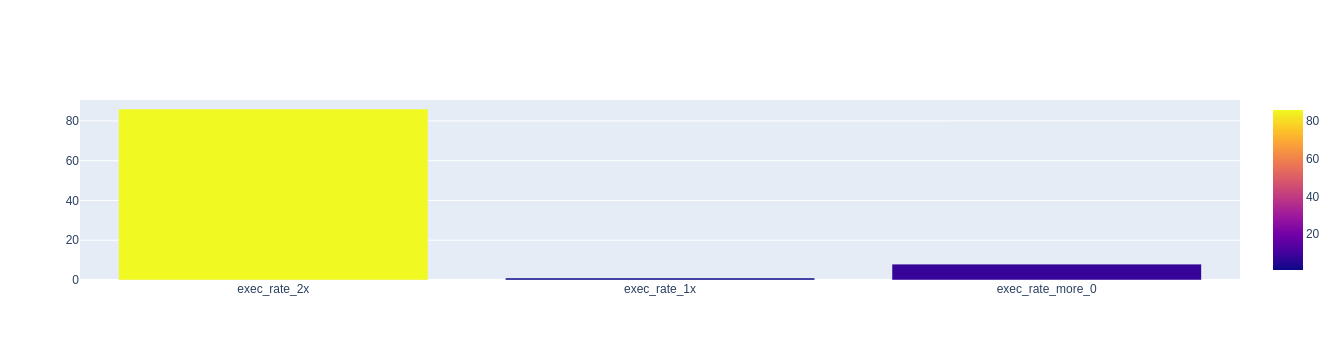

In [84]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['exec_rate_2x', 'exec_rate_1x', 'exec_rate_more_0'], y=lst_exec,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Execution time difference frozen and disabled')
os.rename('temp-plot.html', '{}_Execution time difference frozen and disabled.html'.format(cycle_test))
fig.show()

## query with cardinality error

In [87]:
frozen_df_query_stat_copy=frozen_df_query_stat.copy()

In [88]:
frozen_df_query_stat_copy.columns

Index(['queryid', 'cardinality_error_without_aqo_split',
       'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split',
       'planning_time_with_aqo_split', 'execution_time_without_aqo_split',
       'execution_time_with_aqo_split', 'executions_with_aqo',
       'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo',
       'min_iter_card_without', 'lst_min_val_without_aqo',
       'min_iter_exec_with', 'lst_min_exec_with_aqo',
       'cardinality_error_without_aqo_split_last_value',
       'cardinality_error_with_aqo_split_last_value', 'query_name'],
      dtype='object')

In [89]:
frozen_df_query_stat_copy['diff_card_time']=frozen_df_query_stat_copy['cardinality_error_without_aqo_split_last_value']-frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']

In [90]:
frozen_df_query_stat_copy['rate_card_time']=frozen_df_query_stat_copy['cardinality_error_without_aqo_split_last_value']/frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']

In [91]:
card_rate_2x=frozen_df_query_stat_copy[frozen_df_query_stat_copy['rate_card_time']>=2]

In [92]:
card_rate_1x=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<2) & (frozen_df_query_stat_copy['rate_card_time']>=1)]

In [93]:
card_rate_more_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<1) & (frozen_df_query_stat_copy['rate_card_time']>=0)]

In [94]:
card_rate_less_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<0)]

In [95]:
lst_card=[len(card_rate_2x), len(card_rate_1x), len(card_rate_more_0)]

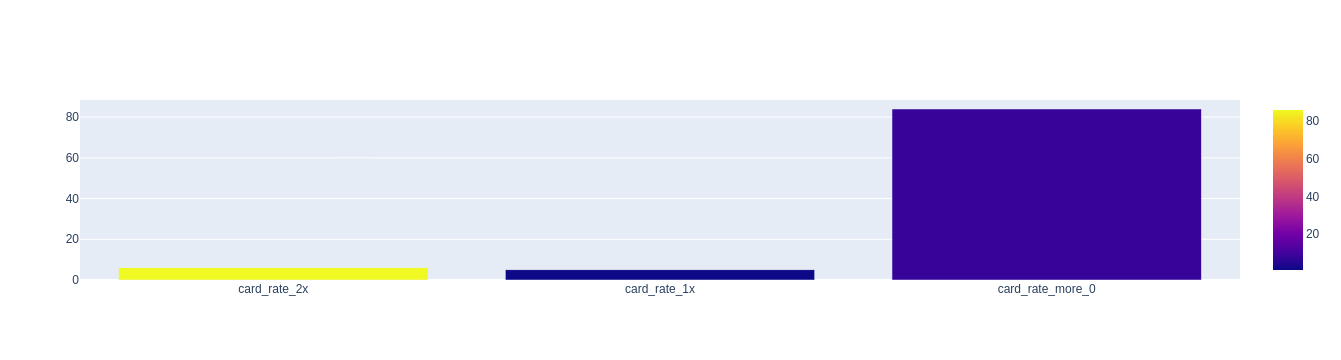

In [96]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['card_rate_2x', 'card_rate_1x', 'card_rate_more_0'], y=lst_card,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [97]:
card_less0_1=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']<=0.15) & (frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']>0)]
card_eq0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']==0)]
card_more0_1=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']>0.15) | (frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']<0)]

In [98]:
frozen_df_query_stat_copy

queryid                cardinality_error_without_aqo_split  \
0     988535410010893112                               [1.1973993742845448]   
1   -6651533820180303979                               [0.7194302660038193]   
2   -3414057395363075461                               [0.9535934648818055]   
3    3350265702090035455                               [3.3309763436625217]   
4    -917204397272063480                               [3.2633813112437693]   
..                   ...                                                ...   
90  -6885312641126422993                                [2.432924086921854]   
91  -1889760809355916724                                [2.812665176668648]   
92  -6571914703387389993                               [1.0491588080704786]   
93   -460740518707800565                               [0.9070590227413717]   
94  -1950505845315524548  [0.9791415628673305, 0.43630343429060897, 1.06...   

                     cardinality_error_with_aqo_split  \
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4   [0.04699718918678322, 0.017621962358924756, 0....   
..                                                ...   
90  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
91  [1.5959811441045022, 0.05338654940017887, 0.00...   
92  [0.0036089565574195276, 0.0036089565574195276,...   
93  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
94  [0.011538125913381528, 0.025015150933378454, 0...   

            planning_time_without_aqo_split  \
0                             [0.013328599]   
1                             [0.026532126]   
2                             [0.008796801]   
3                             [0.028110362]   
4                              [0.02097922]   
..                                      ...   
90                            [0.007251653]   
91                            [0.318759949]   
92                            [0.323461564]   
93                            [0.064528428]   
94  [0.007364701, 0.007499541, 0.008237995]   

                         planning_time_with_aqo_split  \
0   [0.02607165, 0.026364898, 0.026838163, 0.02748...   
1   [0.032843106, 0.033976709, 0.031639636, 0.0306...   
2   [0.015415152, 0.018611165, 0.016028334, 0.0152...   
3   [0.052296671, 0.056458054, 0.051228763, 0.0473...   
4   [0.034765172, 0.037754552, 0.035199055, 0.0337...   
..                                                ...   
90  [0.013010422, 0.01327941, 0.014793134, 0.01299...   
91  [2.646650095, 3.056965264, 2.947018575, 2.6229...   
92  [5.409503806, 5.396519176, 5.278647151, 5.6596...   
93  [0.11832549, 0.108062192, 0.107233379, 0.10761...   
94  [0.012487156, 0.011652769, 0.014375206, 0.0123...   

           execution_time_without_aqo_split  \
0                             [0.113734554]   
1                      [2.5214877060000003]   
2                             [0.170372451]   
3                            [55.537751228]   
4                            [35.606235867]   
..                                      ...   
90                            [0.101933066]   
91                            [1.650203901]   
92                            [0.042353235]   
93                            [0.643301635]   
94  [0.199733573, 0.128297623, 0.232824369]   

                        execution_time_with_aqo_split  executions_with_aqo  \
0   [0.102996816, 0.102158973, 0.100839931, 0.1012...                   34   
1   [0.202374087, 0.187331974, 0.189826482, 0.1825...                   34   
2   [0.172735702, 0.224272353, 0.17789916, 0.17602...                   34   
3   [10.447891804, 10.735650487000001, 10.91341915...                   34   
4   [14.556416143, 13.99166912, 14.066572408, 14.0...                   34   
..                                                ...                  ...   
90  [0.101118331, 0.10

In [99]:
lst_card=[len(card_less0_1),len(card_eq0),len(card_more0_1)]

In [100]:
lst_card

[19, 0, 76]

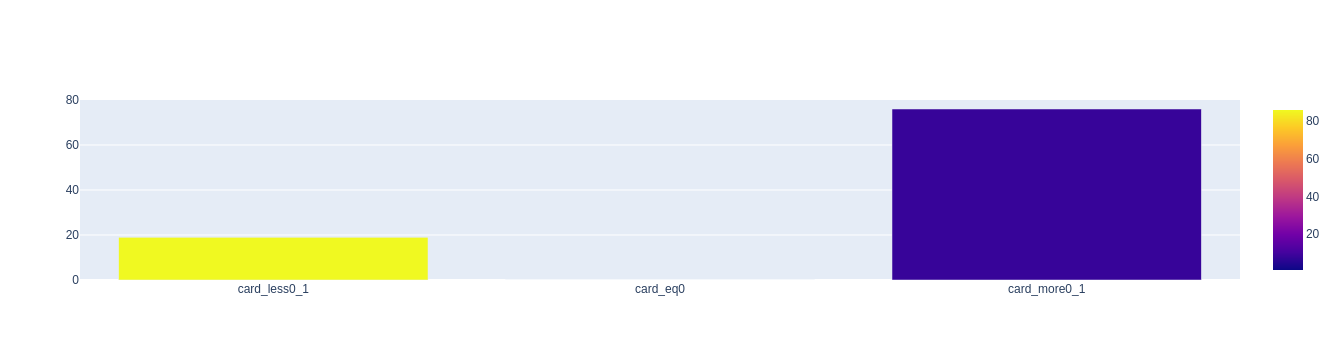

In [101]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['card_less0_1', 'card_eq0', 'card_more0_1'], y=lst_card,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [102]:
frozen_df_query_stat_copy.columns

Index(['queryid', 'cardinality_error_without_aqo_split',
       'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split',
       'planning_time_with_aqo_split', 'execution_time_without_aqo_split',
       'execution_time_with_aqo_split', 'executions_with_aqo',
       'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo',
       'min_iter_card_without', 'lst_min_val_without_aqo',
       'min_iter_exec_with', 'lst_min_exec_with_aqo',
       'cardinality_error_without_aqo_split_last_value',
       'cardinality_error_with_aqo_split_last_value', 'query_name',
       'diff_card_time', 'rate_card_time'],
      dtype='object')

In [103]:
df_filter=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time'])>=1]

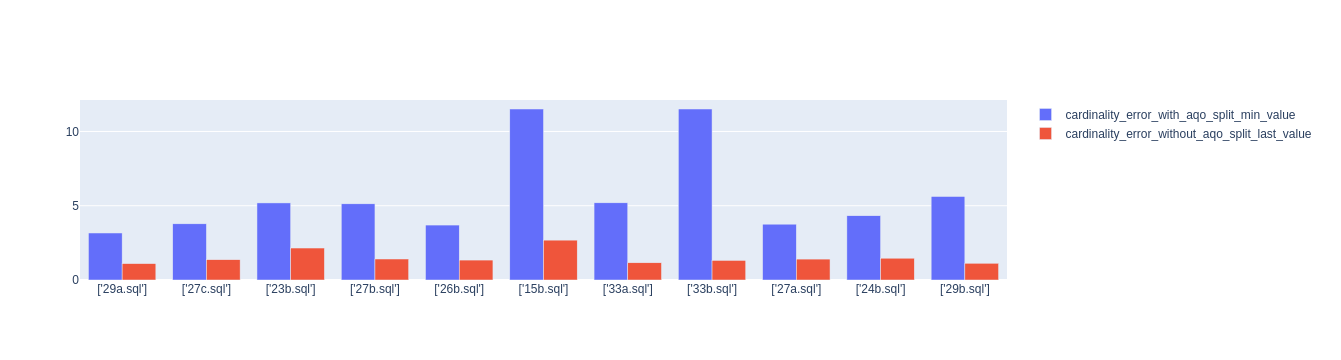

In [104]:
fig = go.Figure()
fig.add_trace(go.Bar(name='cardinality_error_with_aqo_split_min_value',x=df_filter['query_name'], y=abs(np.log(df_filter['lst_min_val_with_aqo']+0.00001))))
fig.add_trace(go.Bar(name='cardinality_error_without_aqo_split_last_value', x=df_filter['query_name'], y=abs(np.log(df_filter['cardinality_error_without_aqo_split_last_value']))))
fig.show()

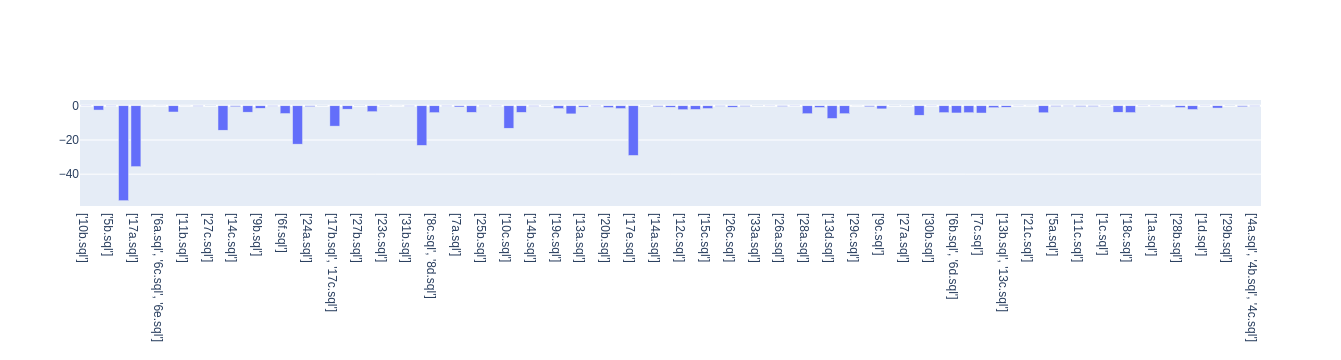

In [105]:
fig = go.Figure()
fig.add_trace(go.Bar(name='cardinality_error',x=frozen_df_query_stat_copy['query_name'], y=frozen_df_query_stat_copy['diff_card_time']))
fig.show()

In [106]:
frozen_df_query_stat_copy['diff_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]-frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [107]:
frozen_df_query_stat_copy[frozen_df_query_stat_copy['diff_exec_time']<0].count()

queryid                                           8
cardinality_error_without_aqo_split               8
cardinality_error_with_aqo_split                  8
planning_time_without_aqo_split                   8
planning_time_with_aqo_split                      8
execution_time_without_aqo_split                  8
execution_time_with_aqo_split                     8
executions_with_aqo                               8
executions_without_aqo                            8
min_iter_card_with                                8
lst_min_val_with_aqo                              8
min_iter_card_without                             8
lst_min_val_without_aqo                           8
min_iter_exec_with                                8
lst_min_exec_with_aqo                             8
cardinality_error_without_aqo_split_last_value    8
cardinality_error_with_aqo_split_last_value       8
query_name                                        8
diff_card_time                                    8
rate_card_ti

In [108]:
frozen_df_query_stat_copy[frozen_df_query_stat_copy['diff_exec_time']>=0].count()

queryid                                           87
cardinality_error_without_aqo_split               87
cardinality_error_with_aqo_split                  87
planning_time_without_aqo_split                   87
planning_time_with_aqo_split                      87
execution_time_without_aqo_split                  87
execution_time_with_aqo_split                     87
executions_with_aqo                               87
executions_without_aqo                            87
min_iter_card_with                                87
lst_min_val_with_aqo                              87
min_iter_card_without                             87
lst_min_val_without_aqo                           87
min_iter_exec_with                                87
lst_min_exec_with_aqo                             87
cardinality_error_without_aqo_split_last_value    87
cardinality_error_with_aqo_split_last_value       87
query_name                                        87
diff_card_time                                